# Co-authorship network - Attributed dynamic embedding 

In [12]:
import numpy as np
from scipy import io
import scipy.sparse as sparse
import glob
import pyemb as eb
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib as mpl
import xgboost as xgb
from sklearn.metrics import accuracy_score

This tutorial illustrates an application of attributed unfolded adjacency spectral embedding (AUASE) (Ceccherini et al., 2024). We use the DBLP dataset (Ley et al., 2009) which is a co-authorship network consisting of bibliography data from computer science from 1996 to 2009. The attributes are derived from the abstracts and titles of the papers published by an author within each time interval. For classification tasks, we assign to each author a ground truth label, which is the subject where most of their papers are published.

AUASE produces a dynamic embedding that combines information from the network (i.e. edges) and node attributes. The resulting embedding is more representative than the UASE embedding as it's able to embed more information in the same space. In this tutorial, we are going to visualise AUASE embeddings and show how they outperform UASE ones with a classification application.  

## Load dataset

In [13]:
# load the adjacency matrices
As = [io.loadmat(f'data/DBLP/DBLP_adjs/adj_matrix_{i}_bin.mat')['A'].astype(np.float64) for i in range(9)]

#load the attribute martices 
files = glob.glob('data/DBLP/DBLP_att/word_count_matrix_*.npz')

Cs = []
for file in files:
    Cs.append(sparse.load_npz(file))
    
# load labels 
with open('data/DBLP/DBLP_labels.pkl', 'rb') as f:
    Z = pickle.load(f)

In [14]:
n = As[0].shape[0]
T = len(As)
p = Cs[0].shape[1]
# number of classes
k = len(np.unique( [item for sublist in Z.values() for item in sublist]))-1

print(f'Number of nodes: {n}')
print(f'Number of time windows: {T}')
print(f'Number of attributes: {p}')
print(f'Number of classes: {k}')

Number of nodes: 10092
Number of time windows: 9
Number of attributes: 4291
Number of classes: 7


The data consists of $T$ binary adjacency matrices $\mathbf{A} \in \mathbb{R}^{n \times n}$, where there is an edge between two nodes if two authors co-authored a publication in that year. We also have $T$ attributes matrices $\mathbf{C} \in \mathbb{R}^{n \times p}$ where $p$ is the total number of words considered, and each row records how many times an author used a word in their abstracts and titles. Finally, the label $\mathbf{Z}$ is the subject where an author published most of their papers in that year. These labels can change over time. 

## Embed the dynamic attributed network

We compare the dynamic network embedding without attributes (UASE) with the attributed embedding (AUASE). We use spherical projection for visualisation and reduce the embedding to two dimensions using TSNE. 

In [15]:
# compute the embeddings
d = 12
AUASE_emb = eb.dyn_embed(As, Cs= Cs, alpha =0.7, norm = True, d=d, method="AUASE")
UASE_emb = eb.dyn_embed(As, d=d, method="UASE")

In [16]:
# compute the degree corrected embeddings
AUASE_emb_dc = eb.degree_correction(AUASE_emb)
UASE_emb_dc = eb.degree_correction(UASE_emb)

An author is inactive in a given year if they didn't publish any paper in that year. When performing TSNE and visualising the embedding, we only consider active authors in each year. This is to prevent a big cluster at zero in the embedding. 

In [17]:
# create and index for the active nodes

Z = {
    key: [int(value) for value in array] for key, array in Z.items()
}
Z_years = []
for key, values in Z.items():
    Z_years.extend(values)

active_idx = np.where(np.array(Z_years) != 7)[0]

Z_active = {key: [item for item in values if item != 7] for key, values in Z.items()}

In [18]:
# compute the t-SNE embeddings

AUASE_tsne_act = TSNE(n_components=2, random_state=0).fit_transform(AUASE_emb_dc[active_idx])
UASE_tsne_act = TSNE(n_components=2, random_state=0).fit_transform(UASE_emb_dc[active_idx])

In [19]:
# split the embeddings by time
ns = [np.sum(np.array(Z[key])!= 7) for key in Z.keys()]
AUASE_tsne_act = np.split(AUASE_tsne_act, np.cumsum(ns)[:-1])
UASE_tsne_act = np.split(UASE_tsne_act, np.cumsum(ns)[:-1])

We plot the AUASE and UASE embedding for the last 3 years: 2007, 2008 and 2009. 

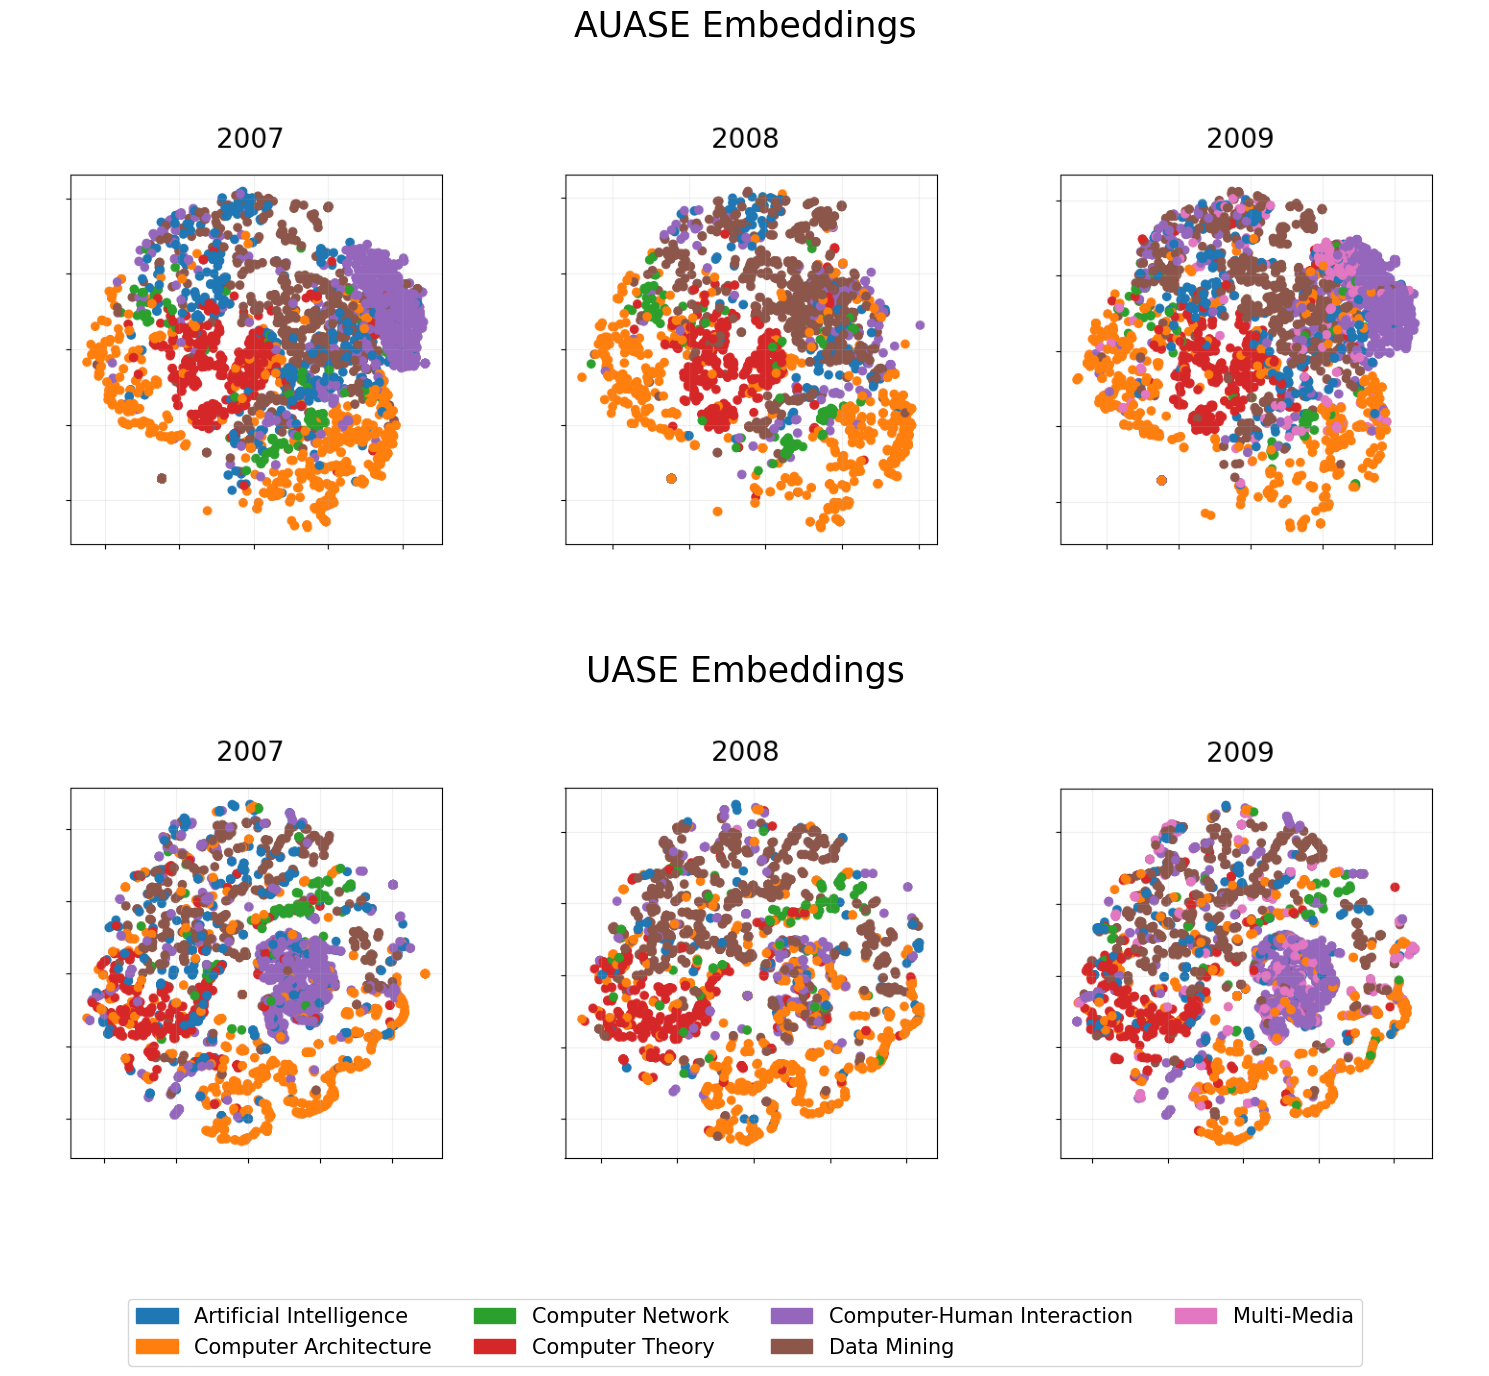

In [20]:
# get all the time windows 
keys = list(Z_active.keys())

# select the colors
colours = np.array(list(mpl.colors.TABLEAU_COLORS.keys())[0:7])
# create a diciontary that map each unique label to a colour
cmap = {i: colours[i] for i in range(0,7)}

# set the legend 
labels_names = {0:'Artificial Intelligence', 
                1:'Computer Architecture',
                2:'Computer Network', 
                3:'Computer Theory', 
                4:'Computer-Human Interaction', 
                5:'Data Mining', 
                6:'Multi-Media'}

# plot the embeddings
fig, axs = plt.subplots(2, 3, figsize=(15, 15))

for i in range(3):
    t = i + 6
    fig_AUASE = eb.plotting.snapshot_plot(
        AUASE_tsne_act[t], 
        n=ns[t], 
        node_labels=Z_active[keys[t]], 
        title=keys[t], 
        show_plot=False, 
        c = cmap
    )
    fig_UASE = eb.plotting.snapshot_plot(
        UASE_tsne_act[t], 
        n=ns[t], 
        node_labels=Z_active[keys[t]], 
        title=keys[t], 
        show_plot=False, 
        c = cmap
    )
    
    # Convert the Matplotlib figure to an image
    canvas = FigureCanvas(fig_AUASE)
    canvas.draw()
    img_AUASE = np.array(canvas.buffer_rgba()) 

    canvas = FigureCanvas(fig_UASE)
    canvas.draw()
    img_UASE = np.array(canvas.buffer_rgba())

    # Display the image in the subplot
    axs[0,i].imshow(img_AUASE)
    axs[0,i].axis("off")  


    axs[1,i].imshow(img_UASE)
    axs[1,i].axis("off")  

fig.text(
    0.5, 0.9,  # x and y position in figure coordinates (0.5 centers it horizontally)
    "AUASE Embeddings", 
    fontsize=25, 
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
)
# Add a title centered between the first and second rows
fig.text(
    0.5, 0.47,  # x and y position in figure coordinates (0.5 centers it horizontally)
    "UASE Embeddings", 
    fontsize=25, 
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
)
# add a legend
fig.legend(
    handles= [mpl.patches.Patch(color=col, label=lab) for lab, col in cmap.items()], 
    labels=[labels_names[i] for i in cmap.keys()], 
    loc='lower center', 
    ncol=4, 
    fontsize=15, 
)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 

plt.show()


AUASE embeddings separate the subject groups better than UASE embeddings; we can see this, especially for Computer architecture and Data mining. We are going to test this claim by using the embeddings for classification. 

## Classification 

We randomly select 50% of the active nodes in each year for training and 50% for testing. We train an XGBost classifier and report the accuracy for each time interval. 

In [21]:
# split the embeddings by time
AUASE_emb_sp = np.split(AUASE_emb_dc, T)
UASE_emb_sp = np.split(UASE_emb_dc, T)

# train a classifier for each time window
for t, key in enumerate(keys):

    perm = np.random.permutation(n)
    train_idx = perm[:n//2].astype(int)
    test_idx = perm[n//2:].astype(int)

    Z_key = np.array(Z[key])

    train_idx = train_idx[Z_key[train_idx] != 7]
    test_idx = test_idx[Z_key[test_idx] != 7]
    
    # XGBoost for classification
    X_train = AUASE_emb_sp[t][train_idx, :]
    X_test = AUASE_emb_sp[t][test_idx, :]
    y_train = Z_key[train_idx]
    y_test = Z_key[test_idx]
    
    model = xgb.XGBClassifier(objective='multi:softprob', num_class=7)

    # Training the model on the training data
    model.fit(X_train, y_train)

    # Making predictions on the test set
    predictions = model.predict(X_test)

    # Calculating accuracy
    accuracy_AUASE = np.round(accuracy_score(y_test, predictions), 3)

    # XGBoost for classification
    X_train = UASE_emb_sp[t][train_idx, :]
    X_test = UASE_emb_sp[t][test_idx, :]
    y_train = Z_key[train_idx]
    y_test = Z_key[test_idx]

    model = xgb.XGBClassifier(objective='multi:softprob', num_class=7)

    # Training the model on the training data
    model.fit(X_train, y_train)

    # Making predictions on the test set
    predictions = model.predict(X_test)

    # Calculating accuracy
    accuracy_UASE = np.round(accuracy_score(y_test, predictions),3)

    print(f'Accuracy at time {key} - AUASE: {accuracy_AUASE} - UASE: {accuracy_UASE}')

Accuracy at time 1996 - 2000 - AUASE: 0.852 - UASE: 0.686
Accuracy at time 2001 - 2002 - AUASE: 0.773 - UASE: 0.7
Accuracy at time 2003 - AUASE: 0.713 - UASE: 0.678
Accuracy at time 2004 - AUASE: 0.881 - UASE: 0.72
Accuracy at time 2005 - AUASE: 0.792 - UASE: 0.73
Accuracy at time 2006 - AUASE: 0.784 - UASE: 0.739
Accuracy at time 2007 - AUASE: 0.801 - UASE: 0.739
Accuracy at time 2008 - AUASE: 0.792 - UASE: 0.722
Accuracy at time 2009 - AUASE: 0.763 - UASE: 0.703


On average, classification on AUASE embedding achieves a 8% higher accuracy than classification on UASE, highlighting AUASE’s ability to achieve a balanced representation of network features and node attributes.

## References 
- Ceccherini, E., Gallagher, I., Jones, A. and Lawson, D.J., 2024. Attributed dynamic network embedding with stability guarantees. Unpublished 
- Ley, M. (2009). Dblp: some lessons learned. Proceedings of the VLDB Endowment, 2(2):1493–1500